# Rescomp Data Analysis

In [1]:
import rescomp as rc
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
from glob import glob
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

--------------------------------------------------------------------------

  Local host:   login03
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
results_path = '/nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/'
p_thins = np.concatenate((np.arange(0, 0.8, 0.1), np.arange(0.8, 0.99, 0.02)))
rhos = [0.1,0.9,1.0,1.1,2.0,5.0,10.0,25.0,50.0]

In [3]:
def get_file_data(hdf5_file='results/erdos_results_0.h5'):
    """
    
    """

    with h5py.File(hdf5_file, 'r') as file:
        vpt_thinned_list = []
        div_pos_thinned_list = []
        div_der_thinned_list = []
        consistency_thinned_list = []

        for group_name in file.keys():
            group = file[group_name]
            if 'mean_vpt_thinned' not in list(group.attrs):
                continue
            vpt_thinned_list.append(group.attrs['mean_vpt_thinned'])
            div_pos_thinned_list.append(group.attrs['div_pos_thinned'])
            div_der_thinned_list.append(group.attrs['div_der_thinned'])
            consistency_thinned_list.append(group.attrs['mean_consistency_thinned'])
            # print('{}, c: {}, vpt_connected: {}, p_thin: {}, vpt_thinned: {}'.format(group_name, c, vpt_connected, p_thin, vpt_thinned))
        # print('vpt_connected_average: {}, vpt_thinned_average: {}'.format(np.mean(vpt_connected_list), np.mean(vpt_thinned_list)))
        
        mean_vpt = np.mean(vpt_thinned_list)
        mean_div_pos = np.mean(div_pos_thinned_list)
        mean_div_der = np.mean(div_der_thinned_list)
        mean_consistency = np.mean(consistency_thinned_list)
        print(f"Number of draws successfully made for {hdf5_file}: {len(vpt_thinned_list)}")
        print(f"Mean diversity: {mean_div_pos, mean_div_der}")
        
        return mean_vpt, mean_div_pos, mean_div_der, mean_consistency

In [4]:
def get_system_data(p_thins, rhos, results_path=results_path):
    """
    
    """
    mean_vpts = np.zeros((len(rhos), len(p_thins)))
    mean_pos_divs = np.zeros((len(rhos), len(p_thins)))
    mean_der_divs = np.zeros((len(rhos), len(p_thins)))
    mean_consistencies = np.zeros((len(rhos), len(p_thins)))

    for i, rho in enumerate(rhos):
        for j, p_thin in enumerate(p_thins):
            hdf5_file = results_path + f"erdos_results_rho={round(rho,2)}_p_thin={round(p_thin,2)}.h5"
            mean_vpts[i,j], mean_pos_divs[i,j], mean_der_divs[i,j], mean_consistencies[i,j] = get_file_data(hdf5_file=hdf5_file)
            print("VPT", mean_vpts[i,j])

    print(f"Overall: {np.max(mean_consistencies), np.min(mean_consistencies)}")
    return mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies

In [5]:
def create_system_plot(values, ax, title, threshold):
    """
    
    """

    cmap = 'viridis'
    # norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(values[np.isfinite(values)]))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=min([np.max(values[np.isfinite(values)]), threshold]))
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create evenly spaced grid for plotting
    x_even = np.linspace(0, 1, len(p_thins))  # evenly spaced x-coordinates
    y_even = np.linspace(0, 1, len(rhos))  # evenly spaced y-coordinates

    # X, Y = np.meshgrid(p_thins, rhos)
    ax.pcolormesh(x_even, y_even, values, shading='nearest', norm=norm, cmap=cmap)
    # ax.pcolormesh(X, Y, values, shading='nearest', cmap=cmap)
    
    ax.set_title(title)
    ax.set_xlabel('p_thin')
    ax.set_ylabel('rho')
    ax.set_xticks(x_even)
    ax.set_xticklabels(p_thins)  # map to original uneven x-values
    ax.set_yticks(y_even)
    ax.set_yticklabels(rhos)  # map to original uneven y-values
    ax.set_aspect('equal', adjustable='box')  # Ensure square cells

    
    # Format the ticks to show 1 decimal place and set them as labels
    ticks = ax.get_xticks()
    ax.set_xticklabels([f'{tick:.1f}' for tick in ticks])

    # Reduce visible x-axis labels
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 3 != 0:  # Show every 3rd label
            label.set_visible(False)
    
    plt.colorbar(mappable=sm, ax=ax)

In [6]:
def create_plots(mean_values=None, thresholds=[10,10,10,10], cutoff=False):
    fig, axs = plt.subplots(1,4, figsize=(14,3.2))
    
    if mean_values is None:
        mean_values = get_system_data(p_thins, rhos, results_path=results_path)

    titles = ['VPT', 'Div_Pos', 'Div_Der', 'Consistency']

    for i in range(len(mean_values)):
        if cutoff:
            mean_values[i][mean_values[i] > thresholds[i]] = 0
        create_system_plot(mean_values[i], axs[i], titles[i], thresholds[i])

    plt.tight_layout()
    plt.show()

### Analysis on c=4

In [7]:
# results_1_path = results_path + 'erdos_results_rho=2.0_p_thin=0.1.h5'
# get_file_data(hdf5_file=results_1_path)

In [8]:
mean_values = get_system_data(p_thins, rhos, results_path=results_path)

Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.1_p_thin=0.0.h5: 3199
Mean diversity: (182.94540632068313, 185.6129835019854)
VPT 0.8708909034073155
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.1_p_thin=0.1.h5: 1656
Mean diversity: (107.44047920786863, 107.48979151851427)
VPT 1.0549758454106288
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.1_p_thin=0.2.h5: 3173
Mean diversity: (153.44032372103896, 154.34144114520635)
VPT 0.9377371572644193
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.1_p_thin=0.3.h5: 1649
Mean diversity: (127.48599963095575, 128.20920578925268)
VPT 0.6708247422680418
Number of draws successfully made for /nobackup/autodelete/usr/seyfda

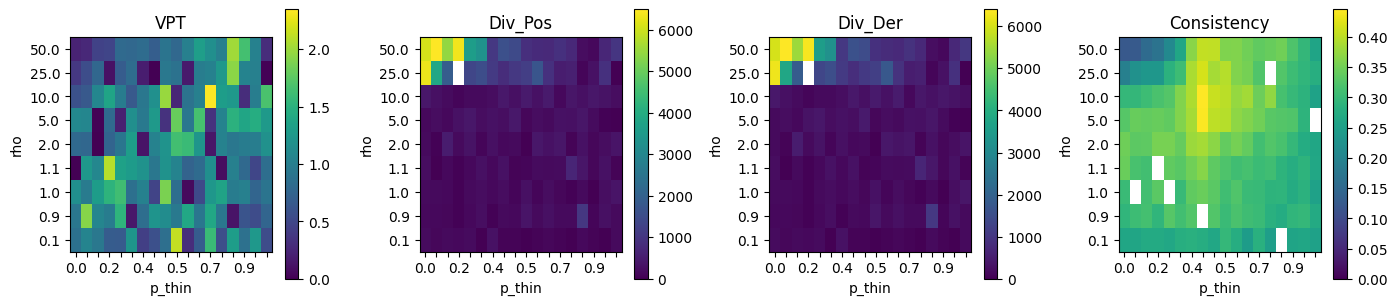

In [24]:
create_plots(mean_values, thresholds=[3, 100000, 100000, 10], cutoff=False)

### Variance of the Diversity Metrics Analysis

In [ ]:
plt.scatter()

In [10]:
print(np.mean(mean_values[1]), np.mean(mean_values[2]))
print(np.mean(mean_values[2][np.isfinite(mean_values[2])]))
print(np.mean(mean_values[1][np.isfinite(mean_values[1])]))
print(np.max(mean_values[2][np.isfinite(mean_values[2])]))
print(np.max(mean_values[1][np.isfinite(mean_values[1])]))
print(np.min(mean_values[2][np.isfinite(mean_values[2])]))
print(np.min(mean_values[1][np.isfinite(mean_values[1])]))

nan nan
558.7850675046312
560.8402826615032
6399.429032700431
6488.181104459959
0.004677940300794339
0.13655845989730986


In [17]:
mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies = np.isfinite(mean_values)

In [18]:
print(np.max(mean_pos_divs), np.max(mean_der_divs))
print(np.min(mean_pos_divs), np.min(mean_der_divs))
print(np.sum(mean_pos_divs > 10000), np.sum(mean_der_divs > 10000))
pos_flat = mean_pos_divs.flatten()
der_flat = mean_der_divs.flatten()
print(len(der_flat))
cov = np.cov(pos_flat, der_flat)
print(cov)

True True
False False
0 0
162
[[0.00617284 0.00617284]
 [0.00617284 0.00617284]]


In [13]:
print(np.divide(mean_pos_divs, mean_der_divs))

[[ 0.98562828  0.99954124  0.99416153  0.99435917  0.99754272  0.75559094
   0.99313282  0.99147266  0.99940334  1.00014109  1.00386008  0.99243674
   0.99016226 29.19200569  0.9968559   0.99633812 22.34642229  0.99848248]
 [ 0.99709373  0.98707872  0.9944841   1.00047456  1.00214069  0.99496887
   0.9921388   0.9982114   0.98846542  0.99345068  0.99542282  0.99725922
   0.9946473   0.99586362  0.98323184  0.99508085  0.99656706  0.99430933]
 [ 0.99031898  0.99348571  0.98520928  1.01131914  1.00081277  0.99265281
   0.99162897  0.99336561  0.98879378  0.99781223  1.0001258   0.9872458
   0.98676894  0.99617098  0.99520067 21.06930179  0.99509279  0.98276199]
 [ 0.99178121 38.19381746  0.99917217  0.99935675  0.99248347  0.9932199
   0.99282975  0.99355084  0.99703958  0.99460365  0.99789157  0.99804137
   0.98757256  0.99525257  0.98591688  0.99864895  0.99514115  1.00423879]
 [ 0.99828926  0.99041557  0.99453272  0.98869458  1.0026661   0.99459418
   0.99080193  1.00515783  0.9952942

In [14]:
threshold = 10

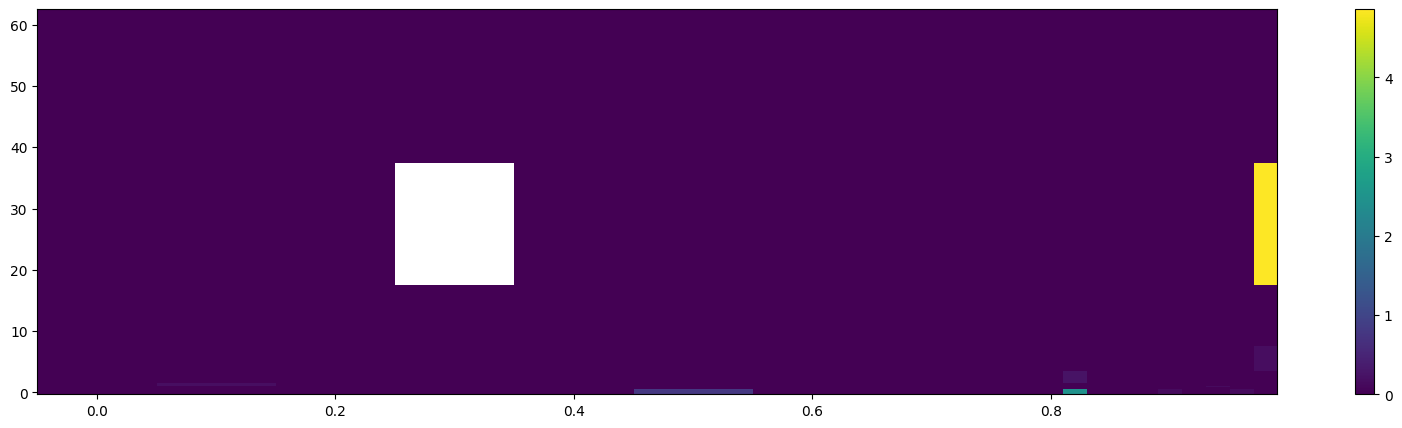

In [ ]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_pos_divs = np.copy(mean_pos_divs)
plot_pos_divs[plot_pos_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_pos_divs)
plt.colorbar()
plt.show()
plt.close()

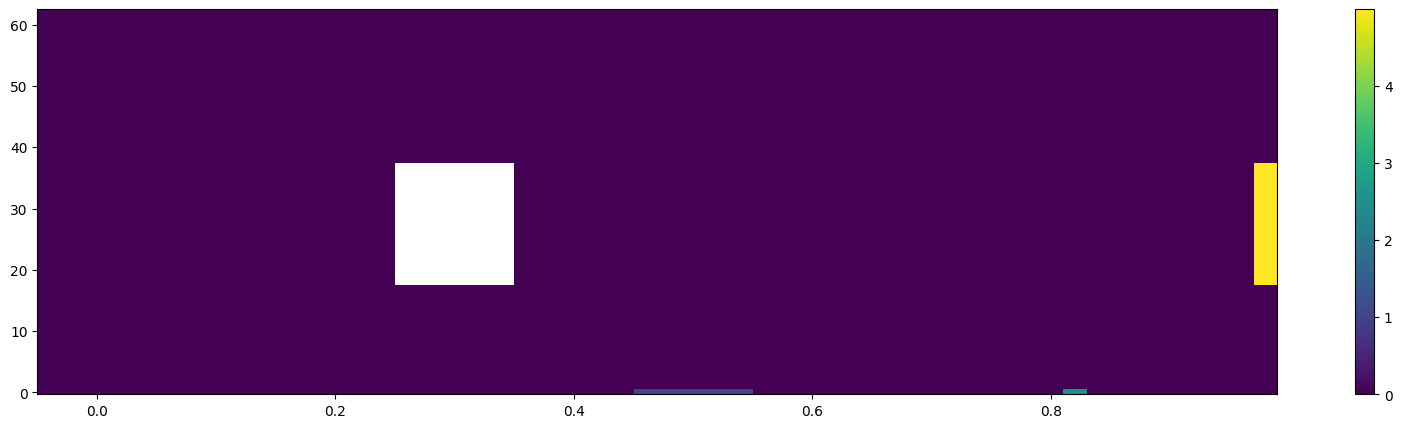

In [ ]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_der_divs = np.copy(mean_der_divs)
plot_der_divs[plot_der_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_der_divs)
plt.colorbar()
plt.show()